# Recurrent Neural Network

In this task, we implement a conventional RNN cell and a GRU to understand RNNs. Then we configurate GRU in special ways such that it either recovers a conventional RNN or keeps its memory in long term.  

In [1]:
# As usual, a bit of setup
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%autosave 180

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


Autosaving every 180 seconds


## Recurrent Neural Networks

In this task, you will need to implement forward calculation of recurrent neural networks. Let's first initialize a problem for RNNs.

In [3]:
## Setup an example. Provide sizes and the input data. 

# set sizes 
time_steps = 5
batch_size = 4
input_size = 3
hidden_size = 2

# create input data with shape [batch_size, time_steps, num_features]
np.random.seed(137)
input_data = np.random.rand(batch_size, time_steps, input_size).astype(np.float32)

### Implement an RNN and a GRU with tensorflow

In [51]:
## Create RNN layers

tf.random.set_seed(137)

# initialize a state of zero for both RNN and GRU
# 'state' is a tensor of shape [batch_size, hidden_size]
initial_state = tf.constant(np.zeros([batch_size, hidden_size]), dtype=tf.float32)

# create a SimpleRNN
tfrnn = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True, return_state=True)

# 'outputs' is a tensor of shape [batch_size, time_steps, hidden_size]
# RNN cell outputs the hidden state directly, so the output at each step is the hidden state at that step
# final_state is the last state of the sequence. final_state == outputs[:, -1, :]

tfrnn_outputs, tfrnn_final_state = tfrnn(input_data, initial_state=initial_state)

# create a GRU RNN
tfgru = tf.keras.layers.GRU(hidden_size, return_sequences=True, return_state=True, reset_after=False)

# 'outputs' and `final_state` are the same for a GRU.
tfgru_outputs, tfgru_final_state = tfgru(input_data, initial_state=initial_state)


### Read out parameters from RNN and GRU cells

**Q1 (0 points)** Understanding `SimpleRNN` and `GRU` parameters

Please read the code and documentation of `get_rnn_params` and `get_gru_params` to see how to read out parameters from these to models. You will need to use these parameters in your own implementations. NO implementation is needed here.


In [83]:
from rnn_param_helper import get_rnn_params, get_gru_params

wt_h, wt_x, bias = get_rnn_params(tfrnn)

wtu_h, wtu_x, biasu, wtr_h, wtr_x, biasr, wtc_h, wtc_x, biasc = get_gru_params(tfgru)


### Numpy Implementation
**Q2 (3 points)** Please implement your own simple RNN. 

Your implementation needs to match the tensorflow calculation.

**Q3 (5 points)** Please implement your own GRU. 

Your implementation needs to match the tensorflow calculation.

In [127]:
from implementation import rnn,gru

# calculation from your own implemenation of a basic RNN
nprnn_outputs, nprnn_final_state = rnn(wt_h, wt_x, bias, initial_state, input_data)


print("Difference between your RNN implementation and tf RNN", 
                    rel_error(tfrnn_outputs, nprnn_outputs) +  rel_error(tfrnn_final_state, nprnn_final_state))

# calculation from your own implemenation of a GRU RNN
npgru_outputs, npgru_final_state = gru(wtu_h, wtu_x, biasu, wtr_h, wtr_x, biasr, wtc_h, wtc_x, biasc, initial_state, input_data)

print("Difference between your GRU implementation and tf GRU", 
      rel_error(tfgru_outputs, npgru_outputs)+ rel_error(tfgru_final_state, npgru_final_state) )


Difference between your RNN implementation and tf RNN 3.7268736856759165e-05
Difference between your GRU implementation and tf GRU 7.71687121593975e-07


### GRU includes RNN as a special case
**Q4 (2 points)** Can you assign a special set of parameters to GRU such that its outputs is almost the same as RNN?

In [130]:
# Assign some value to a parameter of GRU

from implementation import init_gru_with_rnn

wtz_h0, wtz_x0, biasz0, wtr_h0, wtr_x0, biasr0, wtc_h0, wtc_x0, biasc0 = init_gru_with_rnn(wt_h, wt_x, bias)

# concatenate these parameters to initialize GRU kernels
kernel_init = np.concatenate([wtz_x0, wtr_x0, wtc_x0], axis=1)
rec_kernel_init = np.concatenate([wtz_h0, wtr_h0, wtc_h0], axis=1)
bias_init = np.concatenate([biasz0, biasr0, biasc0], axis=0)

grurnn = tf.keras.layers.GRU(hidden_size, 
                            kernel_initializer=tf.keras.initializers.Constant(kernel_init),
                            recurrent_initializer=tf.keras.initializers.Constant(rec_kernel_init), 
                            bias_initializer=tf.keras.initializers.Constant(bias_init),
                            return_sequences=True, return_state=True, reset_after=False)

# 'outputs' is a tensor of shape [batch_size, time_steps, hidden_size]
# Same as the basic RNN cell, final_state == outputs[:, -1, :]
grurnn_outputs, grurnn_final_state = grurnn(input_data, initial_state=initial_state)


# they are the same as the calculation from the basic RNN
print("Difference between RNN and a special GRU", rel_error(tfrnn_outputs, grurnn_outputs))

Difference between RNN and a special GRU 0.0


## Long-term dependency in RNNs

### Long-term dependency in conventional RNNs

In this experiment, we check whether an RNN has long-term memory. Particularly, we initialize the start state with different values. If a later hidden state is the same no matter which initialization is used, then it means that the RNN does not carry the information of the initial state to that hidden state. 

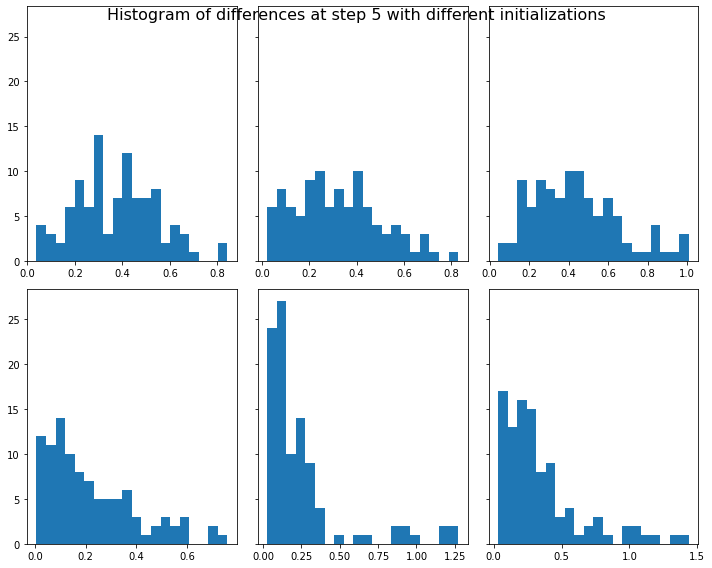

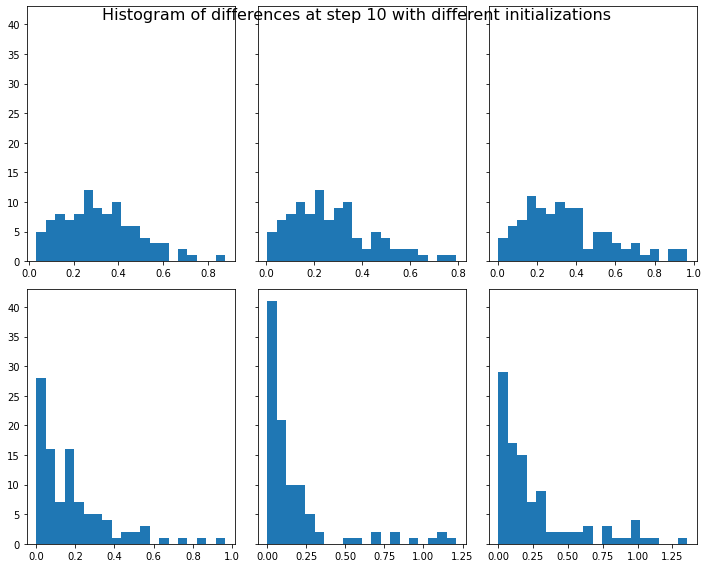

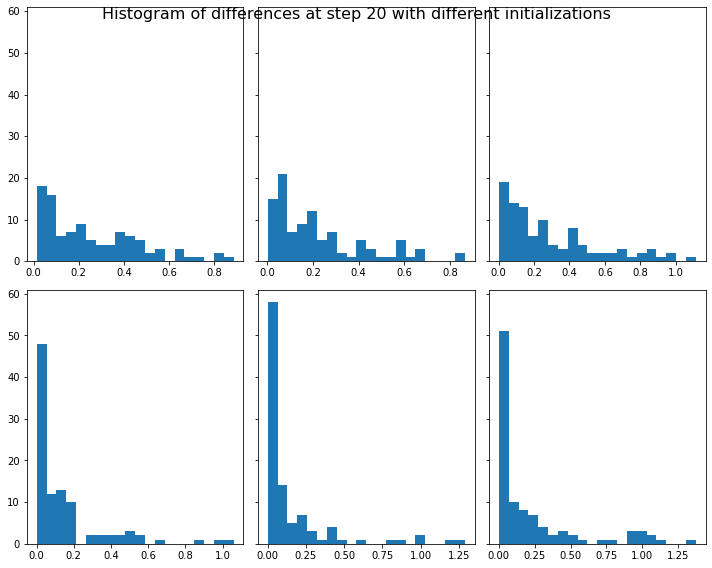

In [136]:
# Create a larger problem

# set sizes 
time_steps = 50
batch_size = 100
input_size = 5
hidden_size = 8

# create input data with shape [batch_size, time_steps, num_features]
np.random.seed(137)
tf.random.set_seed(137)

    
# set values for the basic RNN model

# TODO: play with the scale, and see if you can find any value that achieves long-term memory
scale = 1.0
wt_h2 = ((np.random.rand(hidden_size, hidden_size) - 0.5) * scale).astype(np.float32)
wt_x2 = ((np.random.rand(input_size, hidden_size) - 0.5) * scale).astype(np.float32)
bias2 = ((np.random.rand(hidden_size) - 0.5) * scale).astype(np.float32)

rnn2 = tf.keras.layers.SimpleRNN(hidden_size, 
                                 kernel_initializer=tf.keras.initializers.Constant(wt_x2),
                                 recurrent_initializer=tf.keras.initializers.Constant(wt_h2), 
                                 bias_initializer=tf.keras.initializers.Constant(bias2),
                                 return_sequences=True, return_state=False)


input_data = (np.random.rand(batch_size, time_steps, input_size).astype(np.float32) - 0.5).astype(np.float32)

# intialize the model with different initial states and then calculate the final state
init_states = [np.zeros([batch_size, hidden_size], dtype=np.float32), 
               np.random.random_sample([batch_size, hidden_size]).astype(np.float32), 
               np.random.random_sample([batch_size, hidden_size]).astype(np.float32)]
init_states = init_states + [init_states[1] * 100]


def show_hist_of_hidden_values(outputs, step, title, do_plot=True):
    """ 
    Compute differences of outputs at time step `step` with different initial states. If 
    differences are mostly zero, then it means the initial state does not have effect to the 
    output, which means the memory about the initial state is lost.
    """

    # plot the difference between the four difference settings
    diff_list = []
    
    for i in range(len(outputs) - 1):
        for j in range(i + 1, len(outputs)):
            diff = np.linalg.norm(outputs[i][:, step, :] - outputs[j][:, step, :], axis=1)
            
            diff_list.append(diff)

    diff_frac = 0.0
    for k in range(len(diff_list)):
        diff_frac = diff_frac + np.mean((diff_list[k] > 0.1).astype(np.float32))

    diff_frac = diff_frac / len(diff_list)

    if do_plot:
        # plot the histogram of norms of differences
        n_bins = 20
        fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True)
        plt.suptitle(title, fontsize=16)
    
        for k in range(len(diff_list)):
            axs[k // 3,  k % 3].hist(diff_list[k], bins=n_bins)
    
    return diff_frac

#######################################################################################################

outputs = [None] * len(init_states)

for i in range(len(init_states)): 
    outputs[i] = rnn2(tf.constant(input_data), initial_state = tf.constant(init_states[i]))
    outputs[i] = outputs[i].numpy()
    
    
diff_frac5 = show_hist_of_hidden_values(outputs, 5, 
                           'Histogram of differences at step 5 with different initializations')

diff_frac10 = show_hist_of_hidden_values(outputs, 10, 
                           'Histogram of differences at step 10 with different initializations')

diff_frac20 = show_hist_of_hidden_values(outputs, 20, 
                           'Histogram of differences at step 20 with different initializations')


In [132]:
print('Fractions of differences above 0.1 at step 5, 10, and 20:')
print('%.3f, %.3f, %.3f' % (diff_frac5, diff_frac10, diff_frac20))

Fractions of differences above 0.1 at step 5, 10, and 20:
0.832, 0.712, 0.527


**Q5(3 points)** Interpret the plots above in terms of long-term dependency. (Answers like "These plots indicates the conclusion that ..." will get zero points. You need to clearly indicate which part of the plot is supporting your conclusion and why.) 

*Answer:*  
With steps increasing, fractions of differences above 0.1 decreases. That means when RNN recurs by steps, in figures above, we can find that the differences decreases faster and becomes nearly 0. Thus, it can be summarized that RNN can't carry information of initial state. And with steps grows, the information becomes less, the initial state also nearly influence nothing on growing hidden state.

### Long-term dependency in GRUs

**Q6 (2 points)** Can you set GRU parameters such that it maintains the initial state in the memory for a long term? You can see the histogram of differences, and your code will be graded by the function below. 

In [133]:
from implementation import init_gru_with_long_term_memory

wtz_h, wtz_x, biasz, wtr_h, wtr_x, biasr, wth_h, wth_x, biash = init_gru_with_long_term_memory(wt_h2, wt_x2, bias2)

# concatenate these parameters to initialize GRU kernels
kernel_init = np.concatenate([wtz_x, wtr_x, wth_x], axis=1)
rec_kernel_init = np.concatenate([wtz_h, wtr_h, wth_h], axis=1)
bias_init = np.concatenate([biasz, biasr, biash], axis=0)

gru2 = tf.keras.layers.GRU(hidden_size, 
                            kernel_initializer=tf.keras.initializers.Constant(kernel_init),
                            recurrent_initializer=tf.keras.initializers.Constant(rec_kernel_init), 
                            bias_initializer=tf.keras.initializers.Constant(bias_init),
                            return_sequences=True, return_state=False, reset_after=False)



outputs = [None] * len(init_states)

for i in range(len(init_states)): 
    outputs[i] = gru2(tf.constant(input_data), initial_state = tf.constant(init_states[i]))
    outputs[i] = outputs[i].numpy()
    
    print('Difference between a later hidden state and the initial state is', np.mean(np.abs(outputs[i][:, 20, :] - init_states[i])))
    

Difference between a later hidden state and the initial state is 0.0
Difference between a later hidden state and the initial state is 0.0
Difference between a later hidden state and the initial state is 0.0
Difference between a later hidden state and the initial state is 0.0


## Backpropagation: vanishing gradients and exploding gradients

### Conventional RNN
In the experiment, you will observe vanishing gradients and exploding gradients (mostly vanishing gradients) from a conventional RNN.

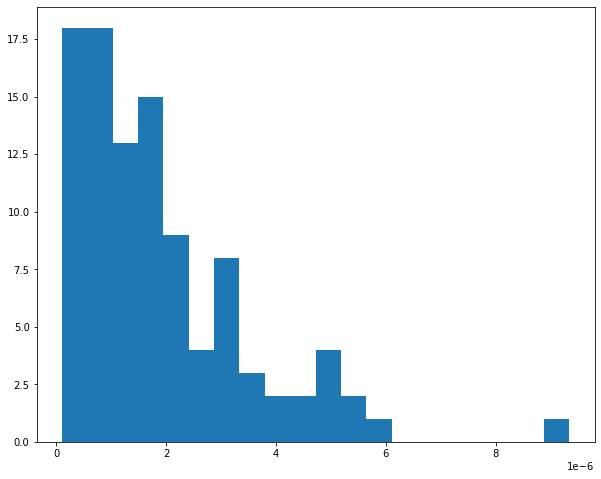

In [134]:
# Calculate gradient with respect to the initial state

# TODO: play with the random seed and the scale and see how likely the gradients are near zero
np.random.seed(2020)
scale = 1.0
wt_h3 = ((np.random.rand(hidden_size, hidden_size) - 0.5) * scale).astype(np.float32)
wt_x3 = ((np.random.rand(input_size, hidden_size) - 0.5) * scale).astype(np.float32)
bias3 = ((np.random.rand(hidden_size) - 0.5) * scale).astype(np.float32)

rnn3 = tf.keras.layers.SimpleRNN(hidden_size, 
                                 kernel_initializer=tf.keras.initializers.Constant(wt_x3),
                                 recurrent_initializer=tf.keras.initializers.Constant(wt_h3), 
                                 bias_initializer=tf.keras.initializers.Constant(bias3),
                                 return_sequences=True, return_state=False)


init_state = tf.Variable(np.random.random_sample([batch_size, hidden_size]), dtype=tf.float32)

with tf.GradientTape(persistent=True) as g:
    g.watch(init_state)
    outputs = rnn3(input_data, initial_state=init_state)
    obj = tf.reduce_sum(tf.square(outputs[:, 30, :]))
    
d_init_state = g.gradient(obj, init_state) 

# show the norms of gradients. Most of them are zero. 
rnn_grad_norm = np.linalg.norm(d_init_state, axis=1)

n_bins = 20
_ = plt.hist(rnn_grad_norm, bins=n_bins)



### GRU

If a GRU is configurated in a way such that it holds its memory, then there is no gradient vanishing problem. 

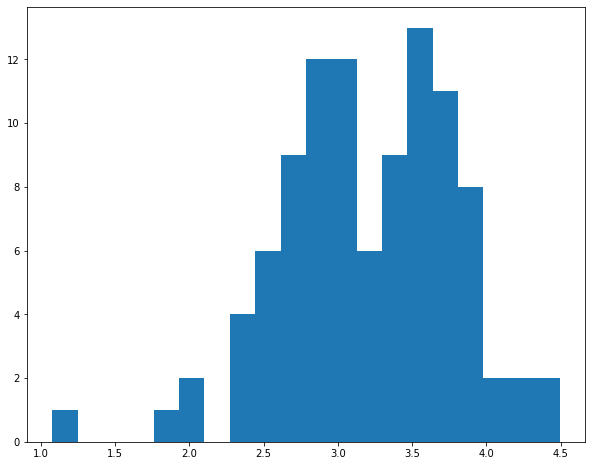

In [135]:

# set up a GRU with long-term memory
wtz_h, wtz_x, biasz, wtr_h, wtr_x, biasr, wth_h, wth_x, biash = init_gru_with_long_term_memory(wt_h3, wt_x3, bias3)

# concatenate these parameters to initialize GRU kernels
kernel_init = np.concatenate([wtz_x, wtr_x, wth_x], axis=1)
rec_kernel_init = np.concatenate([wtz_h, wtr_h, wth_h], axis=1)
bias_init = np.concatenate([biasz, biasr, biash], axis=0)

gru3 = tf.keras.layers.GRU(hidden_size, 
                            kernel_initializer=tf.keras.initializers.Constant(kernel_init),
                            recurrent_initializer=tf.keras.initializers.Constant(rec_kernel_init), 
                            bias_initializer=tf.keras.initializers.Constant(bias_init),
                            return_sequences=True, return_state=False, reset_after=False)



# Feed in an initial state to the GRU and compute the gradient
init_state = tf.Variable(np.random.random_sample([batch_size, hidden_size]), dtype=tf.float32)
with tf.GradientTape(persistent=True) as g:
    g.watch(init_state)
    outputs = gru3(input_data, initial_state=init_state)
    obj = tf.reduce_sum(tf.square(outputs[:, 30, :]))
    
d_init_state = g.gradient(obj, init_state) 

# show the norms of gradients. 
rnn_grad_norm = np.linalg.norm(d_init_state, axis=1)

n_bins = 20
_ = plt.hist(rnn_grad_norm, bins=n_bins)
